# Helper Functions

In [1]:
!pip install lmfit
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import plotly.express as px
import pandas as pd
from lmfit import Parameters
from scipy.integrate import odeint

def PlotStyle(Axes,Title):
    Axes.spines['top'].set_visible(False)
    Axes.spines['right'].set_visible(False)
    Axes.spines['bottom'].set_visible(True)
    Axes.spines['left'].set_visible(True)
    Axes.xaxis.set_tick_params(labelsize=14)
    Axes.yaxis.set_tick_params(labelsize=14)
    Axes.set_title(Title)


def deriv3(y,t,beta,c,p_grp,M10,N10,p_s,sigma,alpha,p_d,p_r):
    S[0],S[1],E[0],E[1],I,D,R=y
    ds1dt = (p_grp * p_s * (lmbda - mu)) - (beta * c * alpha * S[0] *(alpha * (E[0] + I) + E[1]))/Ppl+(M10*S[1])                     
    ds2dt = ((1-p_grp) * p_s * (lmbda - mu)) - (beta * c * S[1] *(alpha * (E[0] + I) + E[1]))/Ppl-(M10*S[1])                     
    de1dt = (p_grp * (1 - p_s) * (lmbda - mu)) + (beta * c * alpha * S[0] *(alpha * (E[0] + I) + E[1]))/Ppl + (N10 * E[1]) - sigma* E[0]                      
    de2dt = ((1-p_grp) * (1 - p_s) * (lmbda - mu)) + (beta * c * S[1] *(alpha * (E[0] + I) + E[1]))/Ppl - ((N10 + sigma) * E[1])                      
    didt = sigma *(E[0] + E[1]) - (p_r + p_d) * I 
    dddt = p_d * I
    drdt = p_r * I
    return ds1dt, ds2dt, de1dt,de2dt,didt,dddt,drdt


def iModSol(t,beta,c,p_grp,M10,N10,p_s,sigma,alpha,p_d,p_r,initCondn):
    y0 = initCondn
    ret = odeint(deriv3, y0, t,args=(beta,c,p_grp,M10,N10,p_s,sigma,alpha,p_d,p_r))
    return ret.T

def Model_fitter(t,beta,c,p_grp,M10,N10,p_s,sigma,alpha,p_d,p_r):
    ret = iModSol(t,beta,c,p_grp,M10,N10,p_s,sigma,alpha,p_d,p_r,initCond)
   # target_e=np.add(ret[4]*w_i,ret[5]*w_d)
    target_e=ret[5]
    return target_e

def Model_pred(t,beta,c,p_grp,M10,N10,p_s,sigma,alpha,p_d,p_r):
    ret = iModSol(t,beta,c,p_grp,M10,N10,p_s,sigma,alpha,p_d,p_r,initCond)
    return ret

# Data Load

In [24]:

URL_DATASET = r'https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv'
df1 = pd.read_csv(URL_DATASET)

startTrainDay = 70
endTrainDay = 140

df=df1[df1['Country']=='United Kingdom'][startTrainDay:endTrainDay]
df_test=df1[df1['Country']=='United Kingdom'][endTrainDay:]


Confirmed_all=np.array(df1[df1['Country']=='United Kingdom']["Confirmed"])
Death_r = np.array(df["Deaths"])
Recovered_r = np.array(df["Recovered"])
Confirmed_r = np.array(df["Confirmed"])
Infected_r=np.subtract(Confirmed_r,np.add(Death_r,Recovered_r))
Death_test=np.array(df_test["Deaths"])

data=Death_r
print(Death_test)
print("data for fitting")
t_len=len(data)
t_len_r=len(Death_r)

print(df)
print(df.shape)
print(df_test.shape)

[41213 41364 41566 41747 41783 41821 42054 42238 42373 42546 42674 42717
 42731 43011 43165 43314 43498 43598 43634 43659 43815 43991 44080 44216
 44283 44305 44321 44476 44602 44687 44735 44883]
data for fitting
             Date         Country  Confirmed  Recovered  Deaths
13338  2020-04-01  United Kingdom      43789        179    3100
13526  2020-04-02  United Kingdom      48718        192    3752
13714  2020-04-03  United Kingdom      53699        208    4467
13902  2020-04-04  United Kingdom      57772        215    5228
14090  2020-04-05  United Kingdom      61422        229    5874
14278  2020-04-06  United Kingdom      66738        287    6445
14466  2020-04-07  United Kingdom      72224        325    7483
14654  2020-04-08  United Kingdom      77387        345    8519
14842  2020-04-09  United Kingdom      82293        359    9623
15030  2020-04-10  United Kingdom      86660        588   10776
15218  2020-04-11  United Kingdom      90273        622   11616
15406  2020-04-12  

# Parameter Grid Search Optimization
This step helps us to find initial values of the parameter estimates

In [4]:
t = np.linspace(0, t_len-1, t_len) # Grid of time points (in days)
t_r=np.linspace(0, t_len_r-1, t_len_r)
Ppl = 66650000       #entire population of US
S = [Ppl*0.1,Ppl*0.9]      #Group1 use preventive measures, group2 doesn't
E = [Infected_r[0]*10,Infected_r[0]*10]
I = Infected_r[0]                  #number of infected people.
D = Death_r[0]                 #number of death.
R = Recovered_r[0] 

lmbda=10500
mu=10000
#Parameters
pfit = Parameters()
#Rate of people in group i. Either person takes precaution or not
pfit.add(name='p_grp', min=0.3, max=0.5, brute_step=0.05)
#Rate of: people is normal.
pfit.add(name='p_s', min=0.6, max=0.9, brute_step=0.1)


pfit.add(name='beta',min=2, max=3.5, brute_step=0.5)

#Average contacts per person per day (function of policies & time) 
pfit.add(name='c', min=0.1, max=0.5, brute_step=0.2)

#Incubation rate, at which infected people develops symptoms.
#pfit.add(name='sigma', value = 0.07 ,vary=False) #0.01 get less infection but more death, death not fit
#pfit.add(name='sigma', value=0.01,min=0, max=0.4) #0.01 get less infection but more death, death not fit
pfit.add(name='sigma', value=0.1,min=0.2, max=0.5, brute_step=0.1)

#Per capita rate of migration of normal ones from group i to j.
pfit.add(name='M10', min=0.1, max=0.5, brute_step=0.1)
#Per capita rate of migration of infected ones from group i to j.
pfit.add(name='N10', min=0.3, max=0.6, brute_step=0.1)

#The rate of death.
pfit.add(name='p_d', min=0.0015, max=0.0025, brute_step=0.005)
#The rate of recovery.
pfit.add(name='p_r', min=0.02, max=0.04, brute_step=0.01)
#Descrease rate of indivisual catching virus
pfit.add(name='alpha', min=0.02, max=0.05, brute_step=0.01)


#p_grp=p_s=0

initCond = (S[0],S[1],E[0],E[1],I,D,R)
pfit.pretty_print()

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
M10         0.1      0.1      0.5     None     True     None      0.1
N10         0.3      0.3      0.6     None     True     None      0.1
alpha      0.02     0.02     0.05     None     True     None     0.01
beta          2        2      3.5     None     True     None      0.5
c           0.1      0.1      0.5     None     True     None      0.2
p_d      0.0015   0.0015   0.0025     None     True     None    0.005
p_grp       0.3      0.3      0.5     None     True     None     0.05
p_r        0.02     0.02     0.04     None     True     None     0.01
p_s         0.6      0.6      0.9     None     True     None      0.1
sigma       0.2      0.2      0.5     None     True     None      0.1


# Initialize minimiser and perform grid search

In [5]:
def Model_fitter_brute(params,t,data):
    beta = params['beta']
    c = params['c']
    p_grp = params['p_grp']
    M10 = params['M10']
    N10 = params['N10']
    p_s = params['p_s']
    sigma = params['sigma']
    alpha = params['alpha']
    p_d = params['p_d']
    p_r = params['p_r']
    #beta,c,p_grp,M10,N10,p_s,sigma,alpha,p_d,p_r
    ret = iModSol(t,beta,c,p_grp,M10,N10,p_s,sigma,alpha,p_d,p_r,initCond)
   # target_e=np.add(ret[4]*w_i,ret[5]*w_d)
    target_e=ret[5]
    return target_e - data

from lmfit import Minimizer, fit_report

params = pfit

fitter = Minimizer(Model_fitter_brute, params, fcn_args=(t,data))
result_brute = fitter.minimize(method='brute', Ns=2, keep=10, workers=4 )

In [6]:
par_name = 'p_s'
indx_shift = result_brute.var_names.index(par_name)
grid_shift = np.unique(result_brute.brute_grid[indx_shift].ravel())
print("parameter = {}\nnumber of steps = {}\ngrid = {}".format(par_name,
                                                                len(grid_shift),
                                                               grid_shift))
print(fit_report(result_brute))

    

parameter = p_s
number of steps = 4
grid = [0.6 0.7 0.8 0.9]
[[Fit Statistics]]
    # fitting method   = brute
    # function evals   = 20736
    # data points      = 70
    # variables        = 10
    chi-square         = 37970872.0
    reduced chi-square = 632847.867
    Akaike info crit   = 944.268426
    Bayesian info crit = 966.753378
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    p_grp:  0.45000000 (init = ?)
    p_s:    0.90000000 (init = ?)
    beta:   2.00000000 (init = ?)
    c:      0.10000000 (init = ?)
    sigma:  0.20000000 (init = 0.1)
    M10:    0.40000000 (init = ?)
    N10:    0.50000000 (init = ?)
    p_d:    0.00150000 (init = ?)
    p_r:    0.03000000 (init = ?)
    alpha:  0.02000000 (init = ?)


# FIT paramter...

In [106]:
from lmfit import Model

fitted_model = Model(Model_fitter)
params = fitted_model.make_params()
#params = pfit
params = result_brute.candidates[1].params

result = fitted_model.fit(data,params, t=t,method='leastsq')
print(result.fit_report())

fparams = result.params.valuesdict()

beta_o = fparams['beta']
c_o = fparams['c']
p_grp_o = fparams['p_grp']

M10_o = fparams['M10']
N10_o = fparams['N10']
p_s_o = fparams['p_s']
sigma_o=fparams['sigma']
alpha_o=fparams['alpha']
p_d_o=fparams['p_d']
p_r_o=fparams['p_r']

[[Model]]
    Model(Model_fitter)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 70
    # variables        = 10
    chi-square         = 37973130.4
    reduced chi-square = 632885.507
    Akaike info crit   = 944.272589
    Bayesian info crit = 966.757542
##  Warning: uncertainties could not be estimated:
    p_grp:  at initial value
    p_s:    at initial value
    p_s:    at boundary
    beta:   at initial value
    beta:   at boundary
    c:      at initial value
    c:      at boundary
    sigma:  at initial value
    sigma:  at boundary
    M10:    at initial value
    N10:    at initial value
    p_d:    at initial value
    p_d:    at boundary
    p_r:    at initial value
    alpha:  at initial value
    alpha:  at boundary
[[Variables]]
    p_grp:  0.40000000 (init = 0.4)
    p_s:    0.90000000 (init = 0.9)
    beta:   2.00000000 (init = 2)
    c:      0.10000000 (init = 0.1)
    sigma:  0.20000000 (init = 0.2)
    M10: 

# Projection of the next 250 days

In [107]:
ext=250+len(Death_test)
t_len

70

In [108]:
ext=250+len(Death_test)
t2 = np.linspace(0, t_len+ext, t_len+ext) # Grid of time points (in days

Pred=Model_pred(t2,beta_o,c_o,p_grp_o,M10_o,N10_o,p_s_o,sigma_o,alpha_o,p_d_o,p_r_o)
Death_e=Pred[5]
Infected_e=Pred[4]
Recovered_e=Pred[6]
Confirmed_e=np.add(Infected_e,np.add(Death_e,Recovered_e))
print(Confirmed_e[-1])
print(Death_e[-1])


957221.2210736568
48448.9262548948


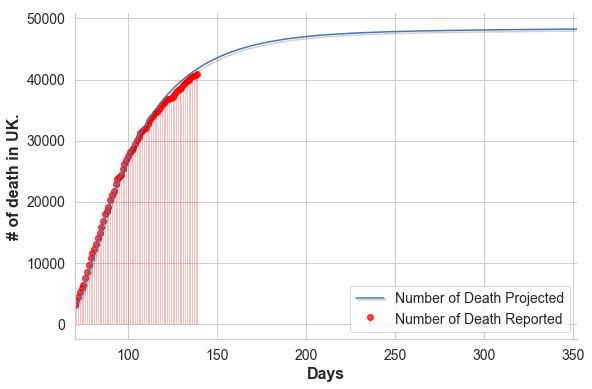

In [109]:

###
#  Curve visualization 
###

import matplotlib.patheffects as path_effects

plt.figure(2,figsize=(9,6))
t_e=range(startTrainDay,startTrainDay+t_len+ext)
t_r=range(startTrainDay,startTrainDay+t_len)

(markers, stemlines, baseline) = plt.stem(t_r,Death_r,bottom=-42,label='Number of Death Reported',basefmt=" ")
plt.setp(stemlines, linestyle="-", color="red", linewidth=0.5,alpha=0.5 )
plt.setp(markers, color="red",alpha=0.75 )
SolutionLabel = r'Number of Death Projected'
#total_infected=np.add(np.array(Recovery_e),np.array(Death_e),np.array(Infected_e))
plt.plot(t_e,Death_e,'b-',label=SolutionLabel,path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
    
plt.xlabel('Days',fontsize=16,fontweight='bold')
plt.ylabel('# of death in UK.',fontsize=16,fontweight='bold')
plt.legend(fontsize=14)

#plt.ylim(0,200000)
plt.xlim(70,t_len+ext)


ax=plt.gca()
PlotStyle(ax,'')


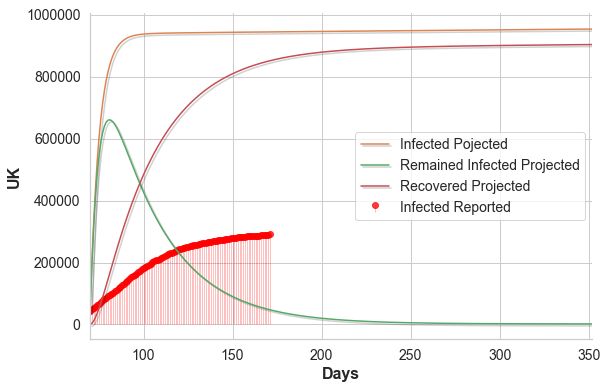

In [114]:
###

import matplotlib.patheffects as path_effects

plt.figure(2,figsize=(9,6))

(markers, stemlines, baseline) = plt.stem(range(0,len(Confirmed_all)), Confirmed_all,bottom=-42,label='Infected Reported',basefmt=" ")
plt.setp(stemlines, linestyle="-", color="red", linewidth=0.5,alpha=0.5 )
plt.setp(markers, color="red",alpha=0.75 )
SolutionLabel = r'Confirmed'

plt.plot(t_e,Confirmed_e,label='Infected Pojected',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(t_e,Infected_e,label='Remained Infected Projected',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(t_e,Recovered_e,label='Recovered Projected',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
#plt.plot(t2,Death_e,label='Death',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
#                       path_effects.Normal()])
    
plt.xlabel('Days',fontsize=16,fontweight='bold')
plt.ylabel('UK',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)

#plt.ylim(0,3000000)
plt.xlim(startTrainDay,t_len+ext)


ax=plt.gca()
PlotStyle(ax,'')


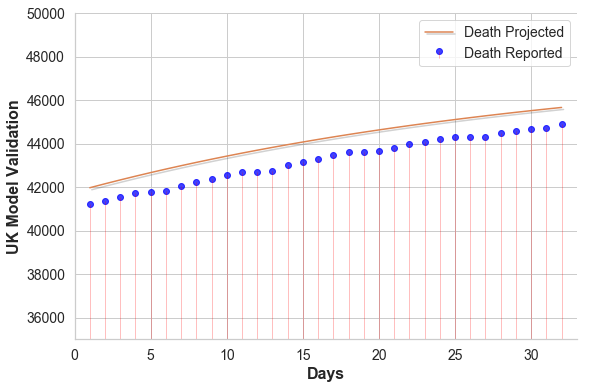

In [111]:


###

import matplotlib.patheffects as path_effects

plt.figure(2,figsize=(9,6))

(markers, stemlines, baseline) = plt.stem(range(1,len(Death_test)+1), Death_test,bottom=-42,label='Death Reported',basefmt=" ")
plt.setp(stemlines, linestyle="-", color="red", linewidth=0.5,alpha=0.5 )
plt.setp(markers, color="blue",alpha=0.75 )
SolutionLabel = r'Confirmed'

plt.plot(range(1,len(Death_test)+1),Death_e[endTrainDay-startTrainDay:endTrainDay-startTrainDay+len(Death_test)],label='Death Projected',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

    
plt.xlabel('Days',fontsize=16,fontweight='bold')
plt.ylabel('UK Model Validation',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)

plt.xlim(0,len(Death_test)+1)
plt.ylim(35000,50000)


ax=plt.gca()
PlotStyle(ax,'')

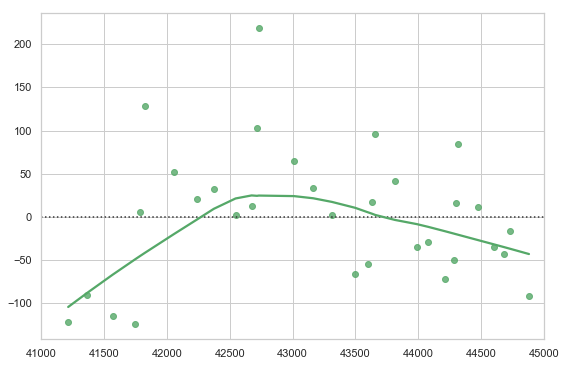

In [112]:
res=np.subtract(Death_e[50:50+len(Death_test)],Death_test)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(2,figsize=(9,6))
plt.xlim(41000,45000)
sns.set(style="whitegrid")
# Plot the residuals

sns.residplot(Death_test,Death_e[endTrainDay-startTrainDay:endTrainDay-startTrainDay+len(Death_test)],  lowess=True, color="g")

